In [1]:
from csv import DictReader

with open('_data/properties_master.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

In [2]:
properties_to_use = [
    'properties.cetane_number.value',
    'properties.ysi_unified.value'
]

samples = []
for row in rows:
    use = True
    for prop in properties_to_use:
        if row[prop] == '-':
            use = False
            break
    if use:
        if float(row['properties.cetane_number.value']) > 100:
            continue
        samples.append(row)

print(len(samples))

145


In [3]:
import numpy as np
from sklearn.preprocessing import RobustScaler

data_cn = np.array([float(s['properties.cetane_number.value']) for s in samples]).reshape(-1, 1)

scaler_cn = RobustScaler()
scaler_cn.fit(data_cn)
data_cn = scaler_cn.transform(data_cn)

print(data_cn.shape)

(145, 1)


In [4]:
from sklearn.model_selection import train_test_split
from ecnet.datasets import QSPRDataset

smiles = [s['canonical_smiles'] for s in samples]
smiles_train, smiles_test, targets_train, targets_test = train_test_split(smiles, data_cn, test_size=0.25, random_state=24)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')

In [5]:
from sklearn.decomposition import PCA
import torch

pca = PCA()
pca.fit(ds_train.desc_vals.detach().numpy())

ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_train.target_vals = ds_train.target_vals.type(torch.float32)

ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)
ds_test.target_vals = ds_test.target_vals.type(torch.float32)

In [6]:
from ecnet import ECNet
from sklearn.metrics import median_absolute_error, r2_score

train_maes = []
train_r2s = []
test_maes = []
test_r2s = []

exp_train = [t[0] for t in targets_train]
exp_test = [t[0] for t in targets_test]

for _ in range(25):

    _model = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 3)
    _, _ = _model.fit(dataset=ds_train, epochs=512, valid_size=0.25, shuffle=True, patience=16, verbose=0, lr=0.001)

    _pred_train = _model(ds_train.desc_vals).detach().numpy()
    _pred_test = _model(ds_test.desc_vals).detach().numpy()

    train_maes.append(median_absolute_error(exp_train, _pred_train))
    train_r2s.append(r2_score(exp_train, _pred_train))
    test_maes.append(median_absolute_error(exp_test, _pred_test))
    test_r2s.append(r2_score(exp_test, _pred_test))

In [7]:
import numpy as np

print(f'Training Set MAE: {np.mean(train_maes)} +/- {np.std(train_maes)}')
print(f'Training Set R2: {np.mean(train_r2s)} +/- {np.std(train_r2s)}')
print(f'Test Set MAE: {np.mean(test_maes)} +/- {np.std(test_maes)}')
print(f'Test Set R2: {np.mean(test_r2s)} +/- {np.std(test_r2s)}')

Training Set MAE: 0.07536208677497405 +/- 0.07511438855299948
Training Set R2: 0.5736545751507914 +/- 1.278958713636812
Test Set MAE: 0.21876659608606633 +/- 0.040445005623411384
Test Set R2: 0.3199591123414638 +/- 1.331810388164978


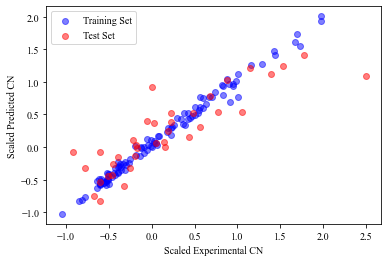

In [8]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental CN')
plt.ylabel('Scaled Predicted CN')
plt.scatter(exp_train, _pred_train, color='blue', alpha=0.5, label='Training Set')
plt.scatter(exp_test, _pred_test, color='red', alpha=0.5, label='Test Set')
plt.legend(loc='upper left')
plt.show()